In [ ]:
# run in psc server

In [ ]:
# from hyppo.independence import Dcorr
from hyppo.independence import MGC
import numpy as np
import pandas as pd
from joblib import Parallel, delayed
from scipy.stats import pearsonr, zscore
import seaborn as sns
import csv
import pickle
import matplotlib.pyplot as plt
import nibabel as nib
import cifti
from nilearn import surface
from nilearn import plotting

/var/tmp/ipykernel_13174/2069034268.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


# 1.prepare data: parcellate dt data

In [ ]:
subfile_path = '/jet/home/hjin1/monkey/scan120_data.list'
monkey_data_path = '/ocean/projects/bio220042p/shared/data/NKI_macaque_awake_anes/data_preprocessed_Bene/data/'
save_path = '/jet/home/hjin1/monkey/pt_data/MarkovCC12_M132_182/'
sub_list = pd.read_csv(subfile_path, delimiter='\t', header=None, names=['sub'])

parcel_label = '/jet/home/hjin1/monkey/parcels/MarkovCC12_M132_182-area.10k_fs_LR.dlabel.nii'
glasserlabel,(ax1,ax2) = cifti.read(parcel_label)


for sub_i in range(len(sub_list)):
    sub_name = sub_list['sub'][sub_i]
    sub_name_save = sub_name.replace('dtseries.nii','MarkovCC12_M132_182-area.10k_fs_LR.dlabel.ptseries.tsv')
    print(sub_name)
    print(sub_i)

    img = nib.load(monkey_data_path+sub_name)
    data_ses = np.array(img.get_fdata())

    ptseries_data = np.zeros((240,182))

    for tr_i in range(240):
        # The first 8897 should be the left hemi, and the second 8897 should be the right hemi
        left_hemi = data_ses[tr_i,0:8897]
        right_hemi = data_ses[tr_i,8897:17794]
        surface_data = np.append(right_hemi, left_hemi,axis =0)

        for parcel_i, parcel_id in enumerate(np.unique(glasserlabel)):
            if parcel_id != 0:
                p_idx = np.where(glasserlabel[0,:]==parcel_id)
                p_coor = np.mean(surface_data[p_idx],axis=0)
                ptseries_data[tr_i,parcel_i-1] = p_coor

    ptseries_df = pd.DataFrame(ptseries_data)
    save_file_path = save_path + sub_name_save
    ptseries_df.to_csv(save_file_path, sep=',', index=False, header=False)

# 2.run mgc-Homotopic

In [ ]:
cd /jet/home/hjin1/monkey/mgc_result/homotopic/MarkovCC12_M132_182


/jet/home/hjin1/monkey/mgc_result/homotopic/MarkovCC12_M132_182


/jet/home/hjin1/.conda/envs/pscmgc/lib/python3.12/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [ ]:
tr=240
p=91
def worker(data,parcel_index_x):
      #zscore
      axis= 0
      data = zscore(data,axis=axis)

      X = data[:,parcel_index_x].reshape(tr, 1)
      Y = data[:,parcel_index_x+p].reshape(tr, 1)
      mgc_stat,mgc_pvalue,mgc_dict=MGC().test(X, Y,reps=1)
      opt_scale = mgc_dict['opt_scale'] # [optimal_x, optimal_scale_y]

      X = data[:,parcel_index_x] #if pearsonr, delete reshape
      Y = data[:,parcel_index_x+p] #parcel 182
      pearson_corr, ____= pearsonr(X,Y)

      output = (parcel_index_x, mgc_stat, opt_scale, pearson_corr)

      return(output)

In [ ]:
subfile_path = '/jet/home/hjin1/monkey/scan120_data.list'
save_path = '/jet/home/hjin1/monkey/pt_data/MarkovCC12_M132_182/'  #MarkovCC12_M132_182
sub_list = pd.read_csv(subfile_path, delimiter='\t', header=None, names=['sub'])

# all states
for sub_i in range(len(sub_list)):
    sub_name = sub_list['sub'][sub_i]
    sub_name_short = sub_name.replace('_DCANBOLDProc_v4.0.0_Atlas.10k.dtseries.nii','')
    sub_name_save = sub_name.replace('dtseries.nii','MarkovCC12_M132_182-area.10k_fs_LR.dlabel.ptseries.tsv')
    print(sub_name_short)
    print(sub_i)

# # awake: motion scrab
# sub_name_save = 'sub-RANDY_ses-combined_task-RESTacq20180920_run-4&5&8'+'_DCANBOLDProc_v4.0.0_Atlas.10k.MarkovCC12_M132_182-area.10k_fs_LR.dlabel.ptseries.tsv'
# sub_name_short = 'sub-RANDY_ses-combined_task-RESTacq20180920_run-4&5&8'

tsv_file = save_path + sub_name_save
df = pd.read_csv(tsv_file, delimiter=',',header=None)
data = np.array(df)

result = Parallel(n_jobs=4, verbose=10)(delayed(worker)(data, parcel_index_x) for parcel_index_x in range(p))
filename = '%s.pkl' % (sub_name_short)

output_file = open(filename, 'wb')
pickle.dump(result, output_file)
output_file.close()


# 3.read mgc result

In [ ]:
subfile_path = '/jet/home/hjin1/monkey/scan120_data.list'
sub_list = pd.read_csv(subfile_path, delimiter='\t', header=None, names=['sub-file'])

subfile_path = '/jet/home/hjin1/monkey/scan120_state.list'
state_list = pd.read_csv(subfile_path, delimiter='\t', header=None, names=['state'])

In [ ]:
monkey_120_df = sub_list.merge(state_list, left_index=True, right_index=True)
monkey_120_df['sub-file']=monkey_120_df['sub-file'].str.replace('_DCANBOLDProc_v4.0.0_Atlas.10k.dtseries.nii','')
monkey_120_df['sub-name'] = monkey_120_df['sub-file'].str.extract(r'sub-(.*?)_ses')

In [ ]:
import os
os.chdir('/jet/home/hjin1/monkey/mgc_result/homotopic/MarkovCC12_M132_182')

In [ ]:
monkey_name = 'RANDY' #'' MAJOM RANDY BROOKLYN
isolevels = [0,75,100,150,200]
p=91

# 5 state * 12/8/4 sessions MAJOM/RANDY/BROOKLYN
test_statistic_all = []
pearson_corr_all = []
optimal_scale_X_all = []
optimal_scale_X_nonlinear_binary_all = []

for i, isolevel in enumerate(isolevels):

    test_statistic_each_state = []
    pearson_corr_each_state = []
    optimal_scale_X_each_state = []
    optimal_scale_X_nonlinear_binary_each_state = []
    state_df = monkey_120_df[(monkey_120_df['sub-name']==monkey_name) & (monkey_120_df['state']==isolevel)]

    for file_i in range(len(state_df)):
        filename = state_df['sub-file'].iloc[file_i]+'.pkl'

        tr=240
#         threshold_nonlinear=(tr - np.sqrt(tr))/tr
        threshold_nonlinear=0.95

        with open(filename, 'rb') as pkl_file:
            results = pickle.load(pkl_file)

        test_statistic = np.zeros((p,1))
        pearson_corr = np.zeros((p,1))
        optimal_scale_X = np.zeros((p,1))
        optimal_scale_X_nonlinear_binary = np.zeros((p,1))

        for result_i in results:
            k = int(result_i[0])
            test_statistic[k,:] = result_i[1]
            optimal_scale_X[k,:] = result_i[2][0]
        #     optimal_scale_Y[k,:] = result_i[2][1]
            pearson_corr[k,:] = result_i[3]

            if result_i[2][0] / tr >= threshold_nonlinear:
                optimal_scale_X_nonlinear_binary[k,:] = 0
            else:
                optimal_scale_X_nonlinear_binary[k,:] = 1

        test_statistic_each_state.append(test_statistic)
        pearson_corr_each_state.append(pearson_corr)
        optimal_scale_X_each_state.append(optimal_scale_X)
        optimal_scale_X_nonlinear_binary_each_state.append(optimal_scale_X_nonlinear_binary)

    test_statistic_all.append(test_statistic_each_state)
    pearson_corr_all.append(pearson_corr_each_state)
    optimal_scale_X_all.append(optimal_scale_X_each_state)
    optimal_scale_X_nonlinear_binary_all.append(optimal_scale_X_nonlinear_binary_each_state)

In [ ]:
test_statistic_all_state_mean = []
pearson_corr_all_state_mean = []
optimal_scale_X_all_state_mean = []
optimal_scale_X_nonlinear_binary_all_state_mean = []

for i, isolevel in enumerate(isolevels):
    test_statistic_all_state_mean.append(np.mean(test_statistic_all[i],axis=0))
    pearson_corr_all_state_mean.append(np.mean(pearson_corr_all[i],axis=0))
    optimal_scale_X_all_state_mean.append(np.mean(optimal_scale_X_all[i],axis=0))
    optimal_scale_X_nonlinear_binary_all_state_mean.append(np.mean(optimal_scale_X_nonlinear_binary_all[i],axis=0))

np.shape(optimal_scale_X_nonlinear_binary_all)

(5, 8, 91, 1)

# 4.plot on hemi

In [ ]:
def parcel2vert_r(plabel,theta_img):
    glasserlabel,(ax1,ax2) = cifti.read(plabel)
    numverts = int(glasserlabel.shape[1]/2)
    if len(theta_img.shape) >1:
        numparcels = len(theta_img)
    else:
        numparcels = 1
        theta_img = np.reshape(theta_img,[-1,len(theta_img)])
    nparc = np.arange(numparcels)
    data = np.zeros([numparcels,numverts])
    for parcel in nparc:
        for plabel in range(int(np.max((glasserlabel)/2)), int(np.max((glasserlabel)))):
            p_idx = np.where(glasserlabel[0,:]==plabel+1)
            plabel = plabel-91 #hardcode!!
            data[parcel,p_idx] = theta_img[parcel,plabel]
    return data


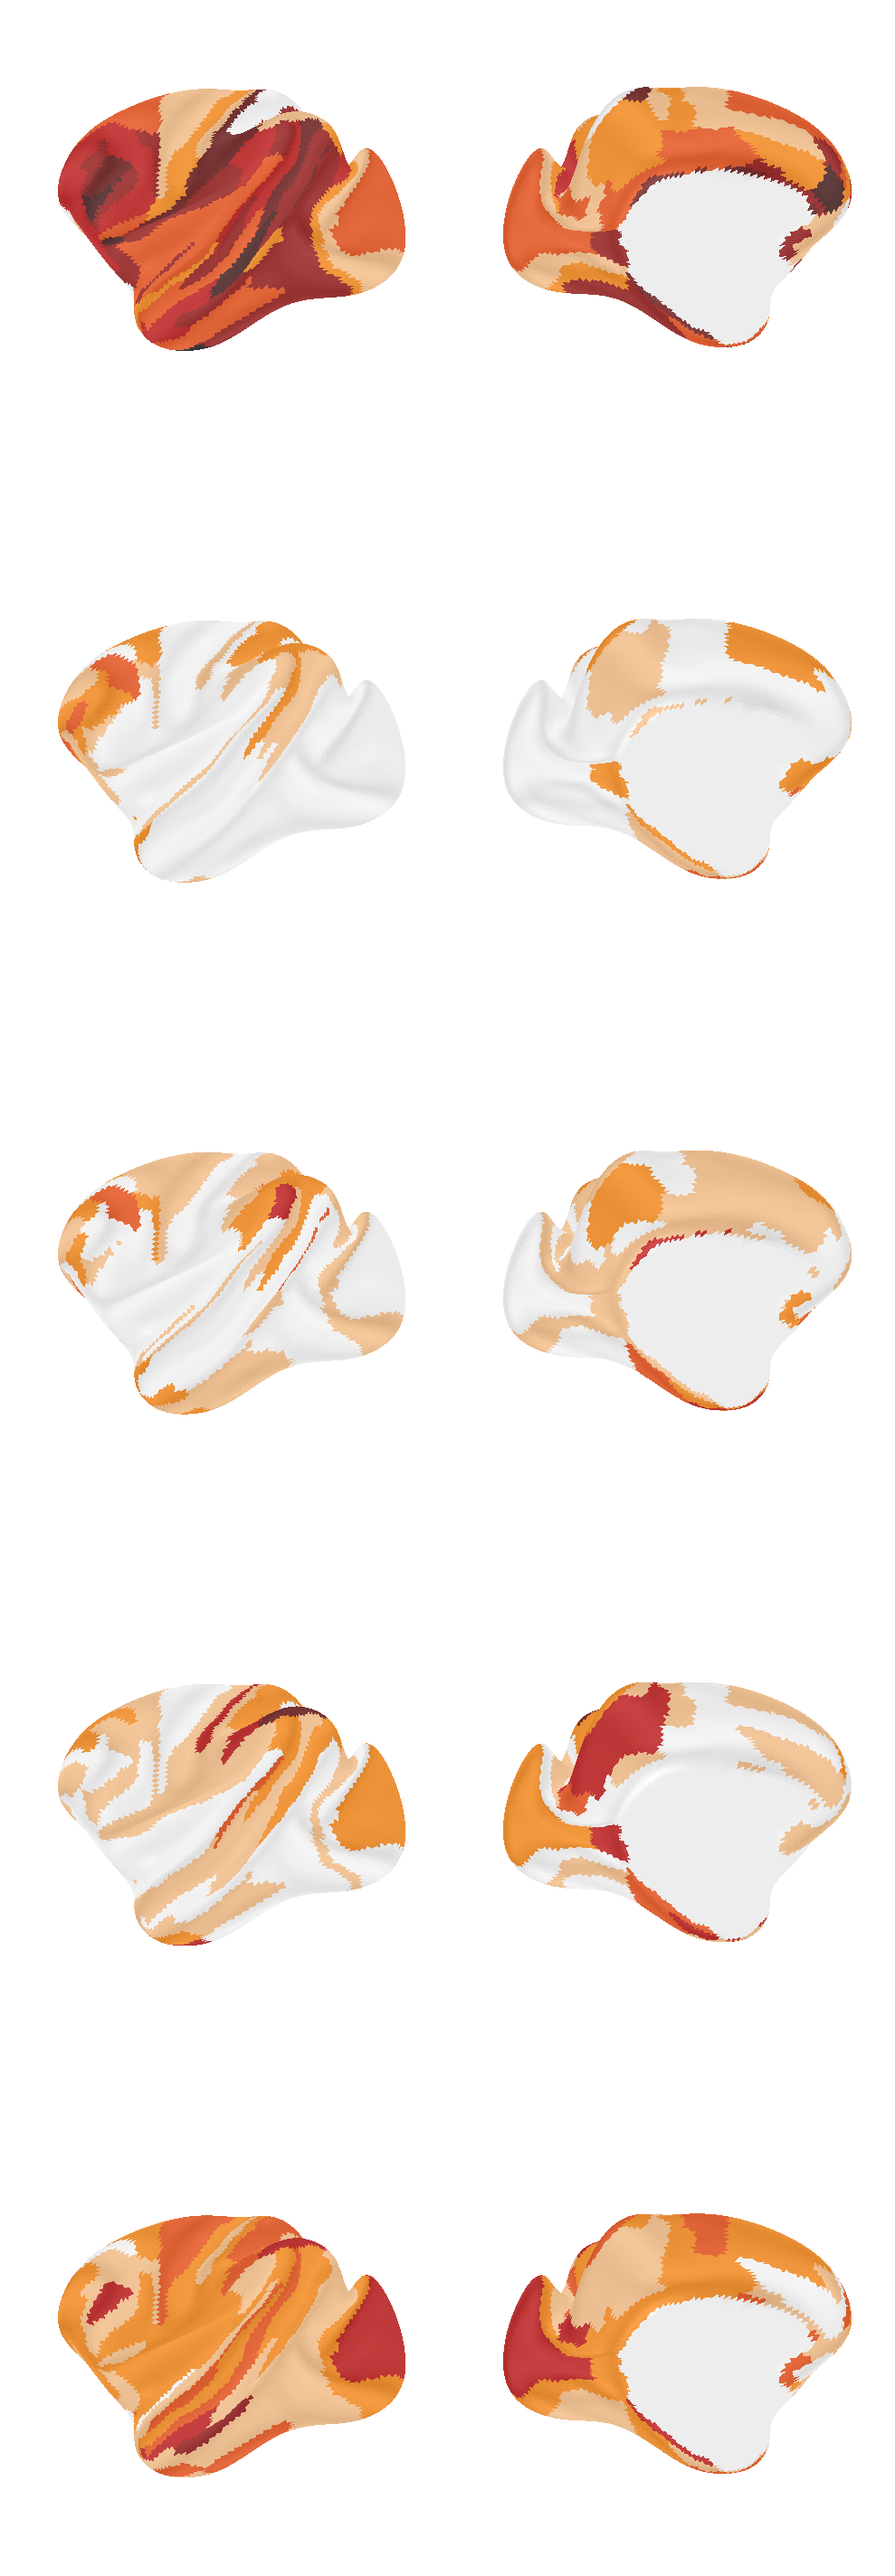

In [ ]:
parcel_label = '/jet/home/hjin1/monkey/parcels/MarkovCC12_M132_182-area.10k_fs_LR.dlabel.nii'
isolevels = [0,75,100,150,200]
ROI_Limg = nib.load('/jet/home/hjin1/monkey/parcels/L.atlasroi.10k_fs_LR.shape.gii')
L_imagemask = np.array(ROI_Limg.darrays[0].data)
ROI_Rimg = nib.load('/jet/home/hjin1/monkey/parcels/R.atlasroi.10k_fs_LR.shape.gii')
R_imagemask = np.array(ROI_Rimg.darrays[0].data)
L_data_mask = np.where(L_imagemask == 1)
R_data_mask = np.where(R_imagemask == 1)

bg_map = "/jet/home/hjin1/monkey/parcels/MAJOM.L.midthickness.10k_fs_LR.surf.gii"

rsurf = surface.load_surf_mesh('/jet/home/hjin1/monkey/parcels/MAJOM.R.inflated.10k_fs_LR.surf.gii')
lsurf = surface.load_surf_mesh('/jet/home/hjin1/monkey/parcels/MAJOM.L.inflated.10k_fs_LR.surf.gii')

vmat10k_r_all_state = []
for i, isolevel in enumerate(isolevels):
    vmat10k_r = np.zeros([10242])
    vmat10k_r[R_data_mask] = parcel2vert_r(parcel_label,np.array((optimal_scale_X_nonlinear_binary_all_state_mean[i]).reshape(1,91)))
    vmat10k_r_all_state.append(vmat10k_r)

plt.figure(figsize=(10,30))
views = ['lateral', 'medial', 'dorsal']
bg_map = '/jet/home/hjin1/monkey/parcels/lh.MacaqueYerkes19.curvature.10k_fs_LR.nii.gz'

cmap = 'gist_heat_r'#'RdBu_r' gist_heat_r  #'seismic'
vmax = 1
vmin = 0

# 5 state * 2 view - homotopic
j=1
for i, isolevel in enumerate(isolevels):
    ax = plt.subplot(5,2,2*j-1, projection='3d') #bg_on_data=False, when plot pearson, R, optimal scale, True, when plot threshold, nonlinear
    plotting.plot_surf(lsurf, vmat10k_r_all_state[i], bg_map=bg_map, bg_on_data=True,hemi='left',view = 'lateral', cmap = cmap, colorbar = False, vmin = vmin, vmax = vmax, avg_method = 'median', alpha = 1, darkness = 0.5, symmetric_cmap=False,axes=ax,threshold=None)

    ax = plt.subplot(5,2,2*j, projection='3d')
    plotting.plot_surf(lsurf, vmat10k_r_all_state[i], bg_map=bg_map, bg_on_data=True, hemi='left',view = 'medial', cmap = cmap, colorbar = False, vmin = vmin, vmax = vmax, avg_method = 'median', alpha = 1, darkness = 0.5, symmetric_cmap=False,axes=ax,threshold=None)

    j+=1

plt.tight_layout()
plt.show()


# 5.Extra: motion scrab and concat awake data

In [ ]:
mc_path = '/ocean/projects/bio220042p/shared/data/NKI_macaque_awake_anes/data_preprocessed_Bene_FD30/'
monkey_name = 'RANDY'#MAJOM BROOKLYN RANDY
save_path = '/jet/home/hjin1/monkey/pt_data/MarkovCC12_M132_182/'

new_pt_data_list = []
for i,file_i in enumerate(monkey_120_df.index[(monkey_120_df['sub-name']==monkey_name) & (monkey_120_df['state']==0)].tolist()):
    mc_file = '{:04d}-'.format(file_i+1) + monkey_120_df.iloc[monkey_120_df.index[(monkey_120_df['sub-name']==monkey_name) & (monkey_120_df['state']==0)].tolist()[i]]['sub-file'] +'_mc.txt'
    print(mc_file)
    mc_df = pd.read_csv(mc_path+mc_file, delimiter='\t', header=None)

    # remove >0.25 and one after
    indices_to_remove = mc_df[mc_df[0] > 0.25].index
    valid_indices_to_remove = []
    for index in indices_to_remove:
        if index + 1 in mc_df.index:
            valid_indices_to_remove.append(index)
            valid_indices_to_remove.append(index + 1)
    cleaned_df = mc_df.drop(valid_indices_to_remove)
    print(len(cleaned_df))

    sub_name_save = monkey_120_df.iloc[monkey_120_df.index[(monkey_120_df['sub-name']==monkey_name) & (monkey_120_df['state']==0)].tolist()[i]]['sub-file']+'_DCANBOLDProc_v4.0.0_Atlas.10k.MarkovCC12_M132_182-area.10k_fs_LR.dlabel.ptseries.tsv'
    tsv_file = save_path + sub_name_save
    df = pd.read_csv(tsv_file, delimiter=',',header=None)
    new_df = df.drop(valid_indices_to_remove)
    new_pt_data_list.append(new_df)


0017-sub-RANDY_ses-combined_task-RESTacq20180920_run-1_mc.txt
132
0018-sub-RANDY_ses-combined_task-RESTacq20180920_run-2_mc.txt
87
0019-sub-RANDY_ses-combined_task-RESTacq20180920_run-3_mc.txt
80
0020-sub-RANDY_ses-combined_task-RESTacq20180920_run-4_mc.txt
61
0021-sub-RANDY_ses-combined_task-RESTacq20180920_run-5_mc.txt
93
0022-sub-RANDY_ses-combined_task-RESTacq20180920_run-6_mc.txt
56
0023-sub-RANDY_ses-combined_task-RESTacq20180920_run-7_mc.txt
58
0024-sub-RANDY_ses-combined_task-RESTacq20180920_run-8_mc.txt
111


In [ ]:
# concat
df1=new_pt_data_list[3].iloc[0:60]
df2=new_pt_data_list[4].iloc[0:80]
df3=new_pt_data_list[7].iloc[0:100]
df_appended = pd.concat([df1, df2,df3], ignore_index=True)

sub_name_save = 'sub-RANDY_ses-combined_task-RESTacq20180920_run-4&5&8' +'_DCANBOLDProc_v4.0.0_Atlas.10k.MarkovCC12_M132_182-area.10k_fs_LR.dlabel.ptseries.tsv'
save_file_path = save_path + sub_name_save
df_appended.to_csv(save_file_path, sep=',', index=False, header=False)


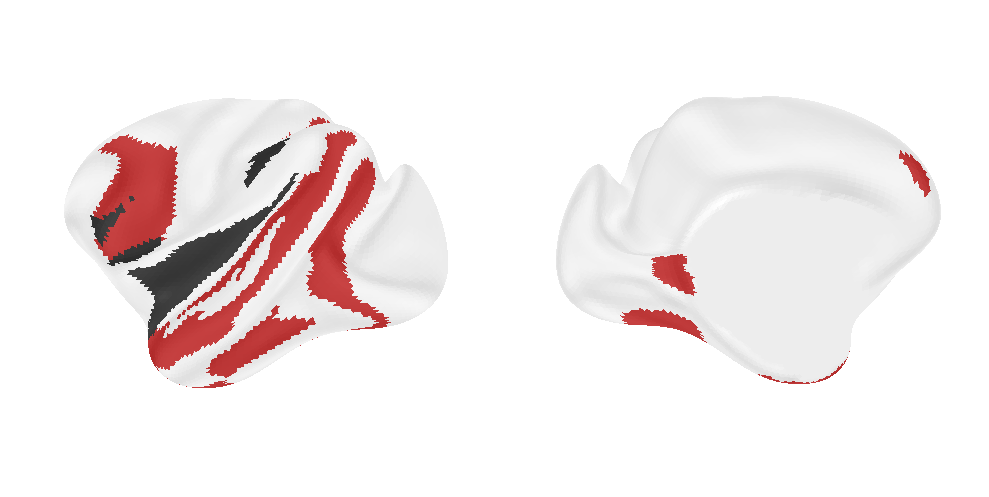

In [ ]:
# plot motion scrab concatnated 000

tr=240
threshold_nonlinear=0.95

# file_name_list =['sub-MAJOM_ses-combined_task-REST_run-01&02.pkl',
#                  'sub-MAJOM_ses-combined_task-REST_run-03&04.pkl',
#                  'sub-MAJOM_ses-combined_task-REST_run-09&10.pkl',
#                  'sub-MAJOM_ses-combined_task-REST_run-11&12.pkl',
#                  'sub-MAJOM_ses-combined_task-REST_run-19&20.pkl',
#                  'sub-MAJOM_ses-combined_task-REST_run-21&22.pkl']
# file_name_list =['sub-BROOKLYN_ses-combined_task-RESTacq20190108_run-1&2.pkl',
#                  'sub-BROOKLYN_ses-combined_task-RESTacq20190108_run-3&4.pkl']
file_name_list=['sub-RANDY_ses-combined_task-RESTacq20180920_run-1&2&3.pkl',
               'sub-RANDY_ses-combined_task-RESTacq20180920_run-4&5&8.pkl']
test_statistic_mean = []
pearson_corr_mean = []
optimal_scale_X_nonlinear_binary_mean = []

for k, filename in enumerate(file_name_list):
    for file_i in range(len(state_df)):
        with open(filename, 'rb') as pkl_file:
            results = pickle.load(pkl_file)

        test_statistic = np.zeros((p,1))
        pearson_corr = np.zeros((p,1))
        optimal_scale_X = np.zeros((p,1))
        optimal_scale_X_nonlinear_binary = np.zeros((p,1))

        for result_i in results:
            k = int(result_i[0])
            test_statistic[k,:] = result_i[1]
            optimal_scale_X[k,:] = result_i[2][0]
        #     optimal_scale_Y[k,:] = result_i[2][1]
            pearson_corr[k,:] = result_i[3]

            if result_i[2][0] / tr >= threshold_nonlinear:
                optimal_scale_X_nonlinear_binary[k,:] = 0
            else:
                optimal_scale_X_nonlinear_binary[k,:] = 1
    test_statistic_mean.append(test_statistic)
    pearson_corr_mean.append(pearson_corr)
    optimal_scale_X_nonlinear_binary_mean.append(optimal_scale_X_nonlinear_binary)



for i, isolevel in enumerate(isolevels):
    vmat10k_r = np.zeros([10242])
#     vmat10k_r[R_data_mask] = parcel2vert_r(parcel_label,np.array(np.mean(test_statistic_mean,axis=0)).reshape(1,91))
    vmat10k_r[R_data_mask] = parcel2vert_r(parcel_label,np.array(np.mean(optimal_scale_X_nonlinear_binary_mean,axis=0)).reshape(1,91))

plt.figure(figsize=(10,30))
views = ['lateral', 'medial', 'dorsal']
bg_map = '/jet/home/hjin1/monkey/parcels/lh.MacaqueYerkes19.curvature.10k_fs_LR.nii.gz'

cmap = 'gist_heat_r'#'RdBu_r' gist_heat_r  #'seismic'
vmax = 1
vmin = 0

j=1

ax = plt.subplot(1,2,2*j-1, projection='3d') #bg_on_data=False, when plot pearson, R, optimal scale, True, when plot threshold, nonlinear
plotting.plot_surf(lsurf, vmat10k_r, bg_map=bg_map, bg_on_data=True,hemi='left',view = 'lateral', cmap = cmap, colorbar = False, vmin = vmin, vmax = vmax, avg_method = 'median', alpha = 1, darkness = 0.5, symmetric_cmap=False,axes=ax,threshold=None)

ax = plt.subplot(1,2,2*j, projection='3d')
plotting.plot_surf(lsurf, vmat10k_r, bg_map=bg_map, bg_on_data=True, hemi='left',view = 'medial', cmap = cmap, colorbar = False, vmin = vmin, vmax = vmax, avg_method = 'median', alpha = 1, darkness = 0.5, symmetric_cmap=False,axes=ax,threshold=None)

plt.tight_layout()
plt.show()
